# Regression


Model Evaluation Results:
Linear Regression:
  Best Params: {}
  R²: 66.99% | MAE: 5.36


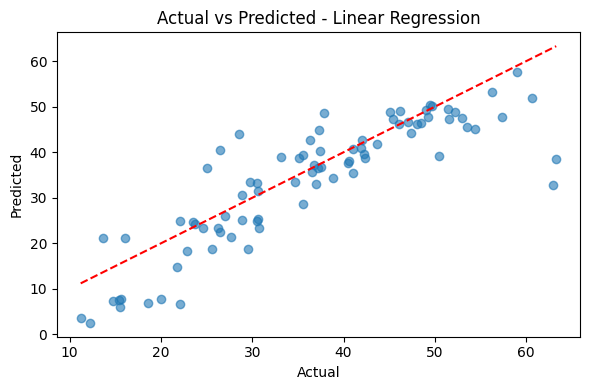


Top 5 features for Linear Regression:
X3 distance to the nearest MRT station    1.103861
X5 latitude                               0.137733
X2 house age                              0.119347
X1 transaction date                       0.028938
X4 number of convenience stores           0.018079
dtype: float64


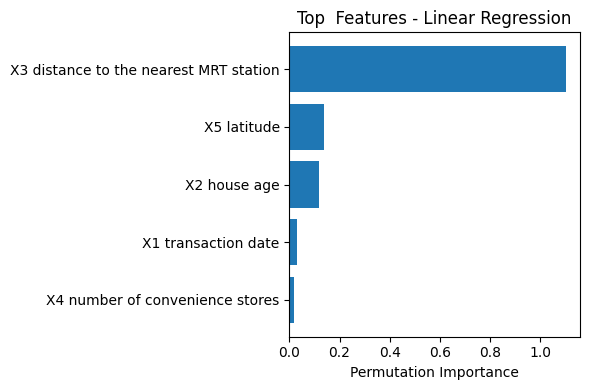

Ridge Regression:
  Best Params: {'transformedtargetregressor__regressor__alpha': 0.1}
  R²: 67.00% | MAE: 5.36


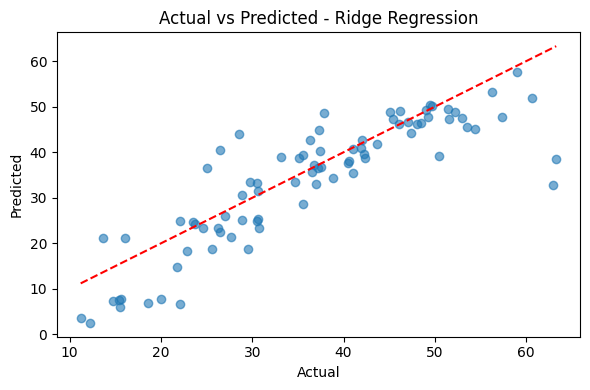


Top 5 features for Ridge Regression:
X3 distance to the nearest MRT station    1.103438
X5 latitude                               0.137675
X2 house age                              0.119316
X1 transaction date                       0.028913
X4 number of convenience stores           0.018118
dtype: float64


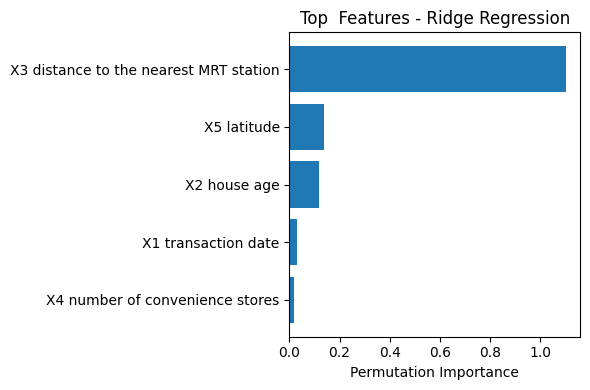

Lasso Regression:
  Best Params: {'transformedtargetregressor__regressor__alpha': 0.0001}
  R²: 67.01% | MAE: 5.36


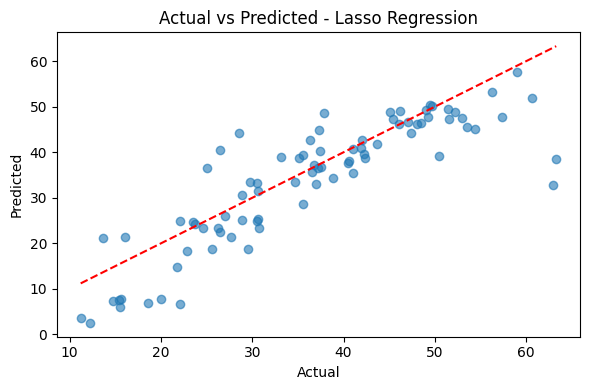


Top 5 features for Lasso Regression:
X3 distance to the nearest MRT station    1.103752
X5 latitude                               0.137592
X2 house age                              0.119186
X1 transaction date                       0.028844
X4 number of convenience stores           0.018067
dtype: float64


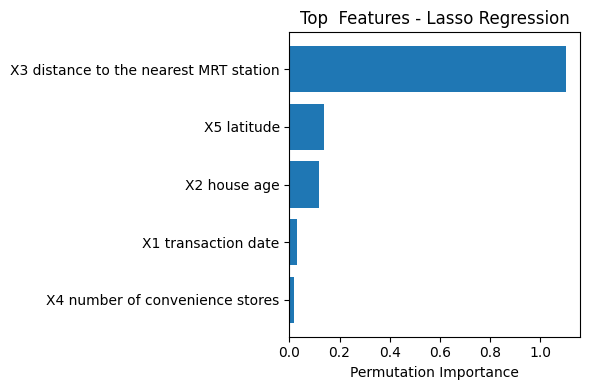

SVR:
  Best Params: {'transformedtargetregressor__regressor__C': 1, 'transformedtargetregressor__regressor__epsilon': 0.01, 'transformedtargetregressor__regressor__kernel': 'rbf'}
  R²: 49.08% | MAE: 6.38


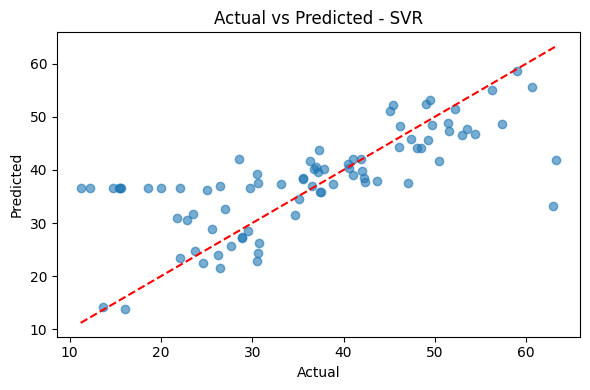


Top 5 features for SVR:
X3 distance to the nearest MRT station    0.225410
X5 latitude                               0.218791
X2 house age                              0.134854
X4 number of convenience stores           0.047660
X1 transaction date                       0.042349
dtype: float64


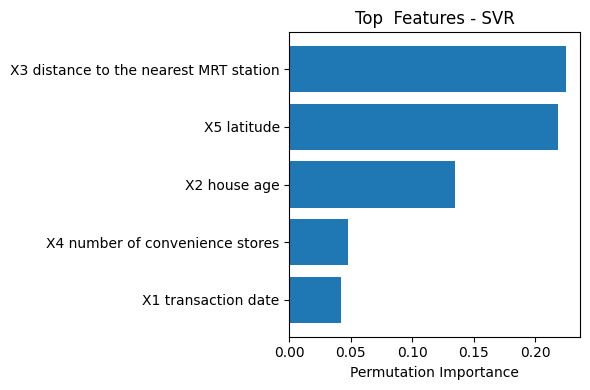

Decision Tree:
  Best Params: {'transformedtargetregressor__regressor__max_depth': 3, 'transformedtargetregressor__regressor__min_samples_split': 5}
  R²: 62.64% | MAE: 6.17


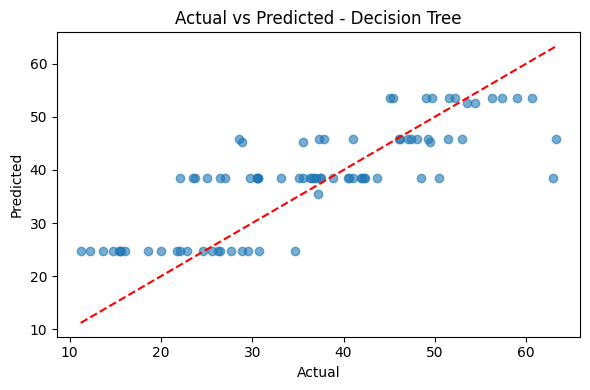


Top 5 features for Decision Tree:
X5 latitude                               0.551639
X3 distance to the nearest MRT station    0.452802
X2 house age                              0.135060
X4 number of convenience stores           0.068208
X1 transaction date                       0.000000
dtype: float64


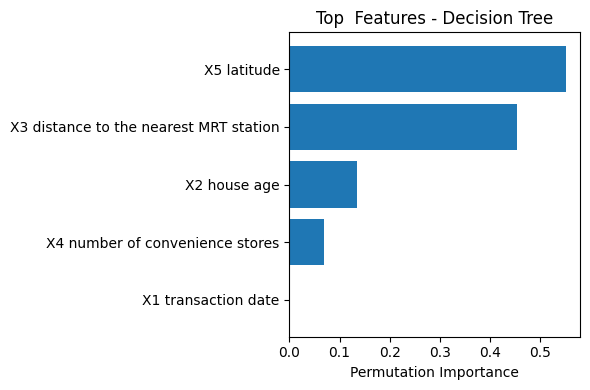

Random Forest:
  Best Params: {'transformedtargetregressor__regressor__max_depth': 5, 'transformedtargetregressor__regressor__n_estimators': 100}
  R²: 77.27% | MAE: 4.53


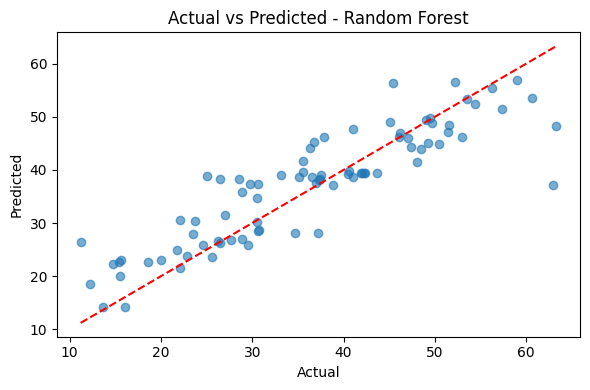


Top 5 features for Random Forest:
X3 distance to the nearest MRT station    0.529063
X5 latitude                               0.423224
X2 house age                              0.197384
X1 transaction date                       0.018163
X4 number of convenience stores           0.002963
dtype: float64


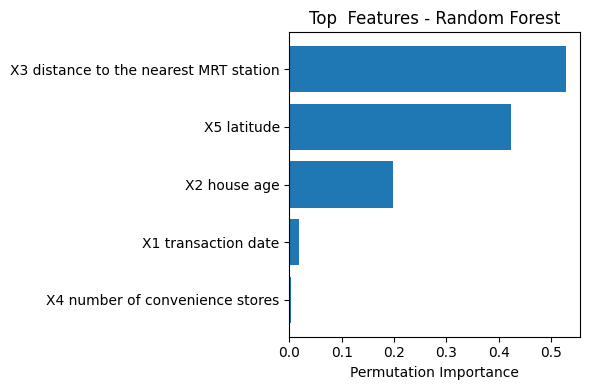

Gradient Boosting:
  Best Params: {'transformedtargetregressor__regressor__learning_rate': 0.05, 'transformedtargetregressor__regressor__max_depth': 3, 'transformedtargetregressor__regressor__n_estimators': 100}
  R²: 75.93% | MAE: 4.27


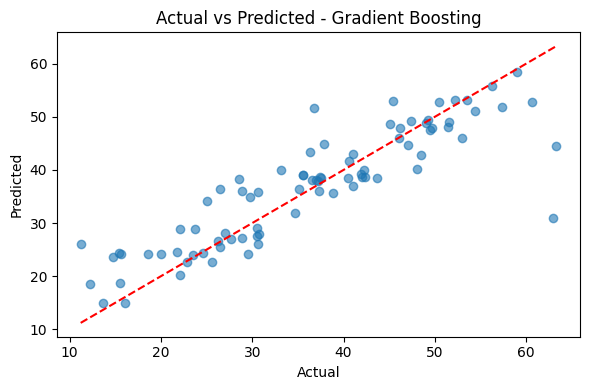


Top 5 features for Gradient Boosting:
X3 distance to the nearest MRT station    0.709053
X5 latitude                               0.294900
X2 house age                              0.130642
X1 transaction date                       0.017576
X4 number of convenience stores           0.004854
dtype: float64


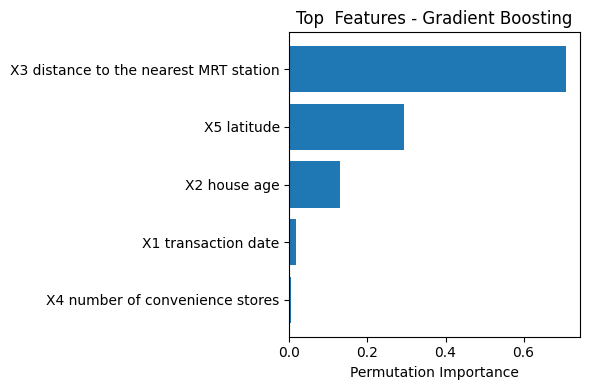


Best Performing Model: Random Forest (77.27% R²)


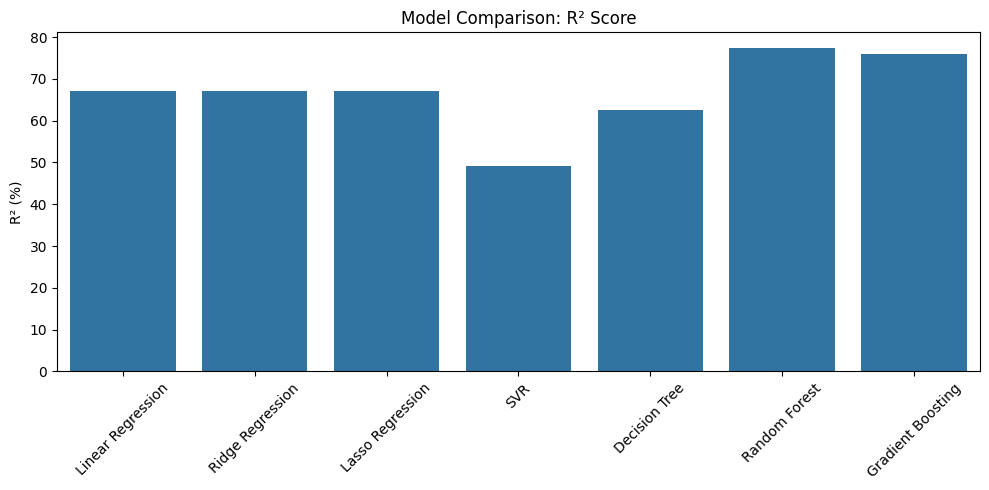

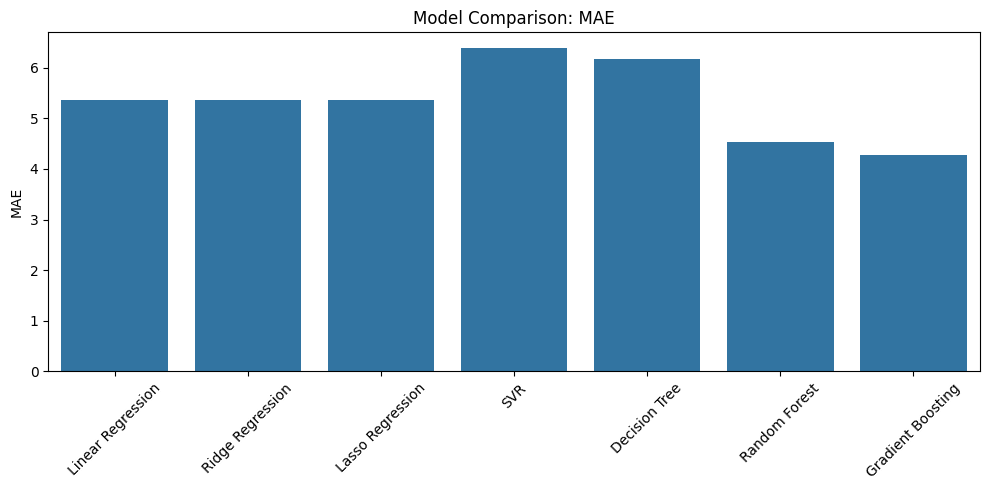

Sample Prediction: 48.99


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance

# --- Step 1: Load and Preprocess Data ---
df = pd.read_csv('/content/Real estate.csv')
numeric_df = df.select_dtypes(include=[np.number])
X = numeric_df.iloc[:, :-1]
y = numeric_df.iloc[:, -1]

not_missing = ~y.isna()
X = X.loc[not_missing]
y = y.loc[not_missing]

# --- Step 2: Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# --- Step 3: Impute Missing Values ---
imputer = SimpleImputer(strategy='median')
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_imputed = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns, index=X_test.index)

# --- Step 4: Outlier Removal ---
def remove_outliers_iqr(df, cols):
    df_filtered = df.copy()
    for col in cols:
        Q1 = df_filtered[col].quantile(0.25)
        Q3 = df_filtered[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df_filtered = df_filtered[(df_filtered[col] >= lower) & (df_filtered[col] <= upper)]
    return df_filtered

X_train_clean = remove_outliers_iqr(X_train_imputed, X_train_imputed.columns)
y_train_clean = y_train.loc[X_train_clean.index]

# --- Step 5: Feature Selection using Correlation ---
correlations = X_train_clean.corrwith(y_train_clean)
correlation_threshold = 0.1
selected_features = correlations[correlations.abs() > correlation_threshold].index.tolist()
if not selected_features:
    selected_features = X_train_clean.columns.tolist()
X_train_clean = X_train_clean[selected_features]
X_test_imputed = X_test_imputed[selected_features]

# --- Step 6: Preprocessor and Transformer ---
preprocessor = make_pipeline(StandardScaler())
target_transformer = FunctionTransformer(func=np.log1p, inverse_func=np.expm1)

# --- Step 7: Model Setup ---
models = {
    "Linear Regression": {"model": LinearRegression(), "params": {}},
    "Ridge Regression": {"model": Ridge(), "params": {"transformedtargetregressor__regressor__alpha": [0.1, 1.0, 10.0]}},
    "Lasso Regression": {"model": Lasso(max_iter=10000), "params": {"transformedtargetregressor__regressor__alpha": [0.0001, 0.001, 0.01]}},
    "SVR": {"model": SVR(), "params": {"transformedtargetregressor__regressor__C": [0.1, 1, 10], "transformedtargetregressor__regressor__epsilon": [0.01, 0.1], "transformedtargetregressor__regressor__kernel": ["rbf", "linear"]}},
    "Decision Tree": {"model": DecisionTreeRegressor(), "params": {"transformedtargetregressor__regressor__max_depth": [None, 3, 5], "transformedtargetregressor__regressor__min_samples_split": [2, 5]}},
    "Random Forest": {"model": RandomForestRegressor(), "params": {"transformedtargetregressor__regressor__n_estimators": [100, 200], "transformedtargetregressor__regressor__max_depth": [None, 5, 10]}},
    "Gradient Boosting": {"model": GradientBoostingRegressor(), "params": {"transformedtargetregressor__regressor__n_estimators": [100, 200], "transformedtargetregressor__regressor__learning_rate": [0.05, 0.1], "transformedtargetregressor__regressor__max_depth": [3, 5]}}
}

def create_pipeline(model):
    return make_pipeline(
        preprocessor,
        TransformedTargetRegressor(regressor=model, transformer=target_transformer)
    )

best_models = {}
r2_scores = {}
mae_scores = {}

print("\nModel Evaluation Results:")

for name, config in models.items():
    pipeline = create_pipeline(config["model"])
    # Hyperparameter tuning if needed
    if config["params"]:
        grid = GridSearchCV(pipeline, param_grid=config["params"], cv=5, scoring='r2', n_jobs=-1)
        grid.fit(X_train_clean, y_train_clean)
        best_est = grid.best_estimator_
        best_params = grid.best_params_
    else:
        pipeline.fit(X_train_clean, y_train_clean)
        best_est = pipeline
        best_params = {}

    best_models[name] = best_est
    # Predictions & metrics
    y_pred = best_est.predict(X_test_imputed)
    r2 = r2_score(y_test, y_pred) * 100
    mae = mean_absolute_error(y_test, y_pred)
    r2_scores[name] = r2
    mae_scores[name] = mae

    print(f"{name}:")
    print(f"  Best Params: {best_params}")
    print(f"  R²: {r2:.2f}% | MAE: {mae:.2f}")

    # Plot: Actual vs Predicted
    plt.figure(figsize=(6,4))
    plt.scatter(y_test, y_pred, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(f"Actual vs Predicted - {name}")
    plt.tight_layout()
    plt.show()

    # Top 5 features for this model
    reg = best_est.named_steps['transformedtargetregressor'].regressor
    # determine importances
    if hasattr(reg, 'feature_importances_'):
        imp = reg.feature_importances_
        label = 'Importance'
    elif hasattr(reg, 'coef_'):
        imp = np.abs(reg.coef_)
        label = '|Coefficient|'
    else:
        perm = permutation_importance(best_est, X_test_imputed, y_test, n_repeats=10, random_state=42, n_jobs=-1)
        imp = perm.importances_mean
        label = 'Permutation Importance'

    feat_imp = pd.Series(imp, index=X_train_clean.columns).sort_values(ascending=False)
    top_n = 5
    print(f"\nTop {top_n} features for {name}:")
    print(feat_imp.head(top_n))

    plt.figure(figsize=(6,4))
    plt.barh(feat_imp.head(top_n).index[::-1], feat_imp.head(top_n)[::-1])
    plt.xlabel(label)
    plt.title(f"Top  Features - {name}")
    plt.tight_layout()
    plt.show()

# --- Step 8: Final Model Selection ---
best_model_name = max(r2_scores, key=r2_scores.get)
best_model = best_models[best_model_name]
print(f"\nBest Performing Model: {best_model_name} ({r2_scores[best_model_name]:.2f}% R²)")

# --- Summary Comparison Plots ---
plt.figure(figsize=(10,5))
sns.barplot(x=list(r2_scores.keys()), y=list(r2_scores.values()))
plt.xticks(rotation=45)
plt.ylabel("R² (%)")
plt.title("Model Comparison: R² Score")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,5))
sns.barplot(x=list(mae_scores.keys()), y=list(mae_scores.values()))
plt.xticks(rotation=45)
plt.ylabel("MAE")
plt.title("Model Comparison: MAE")
plt.tight_layout()
plt.show()

def predict_output(input_values):
    # Create input DataFrame with all original columns, filling missing values with 0
    input_df = pd.DataFrame([input_values], columns=selected_features)
    # Reindex to include all columns, filling missing ones with 0
    input_df = input_df.reindex(columns=X_train.columns, fill_value=0)
    input_imp = pd.DataFrame(imputer.transform(input_df), columns=X_train.columns)
    # Select only the selected features for prediction
    input_imp = input_imp[selected_features]
    return best_model.predict(input_imp)[0]




In [ ]:
# Example:
sample = [2013.167,2.2, 193.5845, 6.0, 24.96571]
print(f"Sample Prediction: {predict_output(sample):.2f}")


Sample Prediction: 48.43
